In [1]:
!pip install torchmetrics
!pip install pytorch_lightning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names = ['Abstract_Expressionism','Baroque','Cubism', 'Fauvism', 'Impressionism','Minimalism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']
device = 'cuda'
!pip install torchsampler
class ArtStyleDataset(Dataset):
  def __init__(self, root_dir, transform = None, transform_tensor = None):
     self.imgs = ImageFolder(root_dir)
     self.root_dir = root_dir
     self.transform = transform
     self.transform_tensor = transform_tensor


  def __len__(self):
        return len(self.imgs)

  def __getitem__(self, idx):
        sample, label = self.imgs[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
#load data
data = ArtStyleDataset('wiki-art-selected-resized-downsampled', transform)

from torch.utils.data import Dataset, DataLoader, random_split
train_size = int(0.8 * len(data))
test_size = int(0.1 * len(data))
val_size = len(data) - train_size - test_size
train_dataset, test_dataset, val_dataset = random_split(data, [train_size, test_size, val_size])

train_loader = DataLoader(train_dataset, shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, shuffle=False, num_workers=4)

from torch.utils.data import WeightedRandomSampler

def extract_labels():
  features = []
  labels_ = []
  map_img_feature = {}
  for inputs, labels in train_loader:
      labels_.append(labels.numpy())
  return labels_
y = extract_labels()
y = np.concatenate(y)
unique, counts = np.unique(y, return_counts=True)


#Up sampling
class_weights = [1.0/c for c in counts]
sample_weights = [class_weights[i] for i in y]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset,sampler=sampler, batch_size= 32)
dataset_sizes= {"train" : len(train_loader), "test" : len(test_loader) , "val" : len(test_loader)}

import torchmetrics
import pytorch_lightning as pl

num_classes = 10

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
Source files will be saved in "/tmp/tmpa4ao4zcd".


In [2]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
import timm

f1_vit = []
accuracy_vit = []
recall_vit = []
precision_vit = []

class ViTClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.validation_step_outputs = []
        self.train_step_outputs = []

        # Freeze pre-trained ViT layers except the classifier
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace classifier with a new head
        self.model.head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )

        # Metrics
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_val = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1_train = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='weighted')
        self.precision_val = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='weighted')
        self.recall_val = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='weighted')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.accuracy.update(preds, y)
        self.f1_train.update(preds, y)

        self.train_step_outputs.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        val_loss = nn.CrossEntropyLoss()(logits, y)

        preds = torch.argmax(logits, dim=1)

        self.val_accuracy.update(preds, y)
        self.f1_val.update(preds, y)
        self.precision_val.update(preds, y)
        self.recall_val.update(preds, y)

        self.validation_step_outputs.append(val_loss)

    def on_train_epoch_end(self):
        train_acc = self.accuracy.compute()
        epoch_f1_train = self.f1_train.compute()
        print(f"Epoch {self.current_epoch}: Train Accuracy: {train_acc:.4f} F1: {epoch_f1_train:.4f}")
        self.accuracy.reset()
        self.f1_train.reset()

    def on_validation_epoch_end(self):
        epoch_val_acc = self.val_accuracy.compute()
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        epoch_f1_val = self.f1_val.compute()
        epoch_precision_val = self.precision_val.compute()
        epoch_recall_val = self.recall_val.compute()

        print(f"Epoch {self.current_epoch}: Validation Accuracy: {epoch_val_acc:.4f} F1: {epoch_f1_val:.4f}  Recall: {epoch_recall_val:.4f}  Precision: {epoch_precision_val:.4f}")
        self.log("validation_epoch_accuracy", epoch_val_acc)
        self.log("validation_epoch_loss", avg_val_loss)
        self.log("f1_val", epoch_f1_val)

        f1_vit.append(epoch_f1_val.cpu().numpy())
        accuracy_vit.append(epoch_val_acc.cpu().numpy())
        recall_vit.append(epoch_recall_val.cpu().numpy())
        precision_vit.append(epoch_precision_val.cpu().numpy())

        self.val_accuracy.reset()
        self.f1_val.reset()
        self.precision_val.reset()
        self.recall_val.reset()

        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        # Optimize only the classifier head
        optimizer = torch.optim.Adam(self.model.head.parameters(), lr=0.0001)
        return optimizer


In [5]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 KB 31.0 MB/s eta 0:00:00


In [3]:
checkpoint_callbackS = ModelCheckpoint(

     monitor='f1_val',
       mode='max',
     dirpath='my/path/',
     filename='transformerVit-{epoch:02d}-{f1_val:.2f}'
)

trainerS = pl.trainer.Trainer(
    max_epochs=25,
   accelerator="cuda",
    callbacks =checkpoint_callbackS,
)

modelResS = ViTClassifier(num_classes=num_classes)

trainerS.fit(modelResS, train_loader, test_loader, ckpt_path=None)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/venv/main/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precis

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.0000 F1: 0.0000  Recall: 0.0000  Precision: 0.0000


/venv/main/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Validation Accuracy: 0.7216 F1: 0.7093  Recall: 0.7216  Precision: 0.7285
Epoch 0: Train Accuracy: 0.5809 F1: 0.5679


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Accuracy: 0.7697 F1: 0.7652  Recall: 0.7697  Precision: 0.7706
Epoch 1: Train Accuracy: 0.7289 F1: 0.7236


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Accuracy: 0.7865 F1: 0.7854  Recall: 0.7865  Precision: 0.7884
Epoch 2: Train Accuracy: 0.7593 F1: 0.7563


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Accuracy: 0.7859 F1: 0.7829  Recall: 0.7859  Precision: 0.7867
Epoch 3: Train Accuracy: 0.7911 F1: 0.7890


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Validation Accuracy: 0.7903 F1: 0.7889  Recall: 0.7903  Precision: 0.7931
Epoch 4: Train Accuracy: 0.8055 F1: 0.8038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Validation Accuracy: 0.8000 F1: 0.7990  Recall: 0.8000  Precision: 0.7995
Epoch 5: Train Accuracy: 0.8230 F1: 0.8219


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Validation Accuracy: 0.8054 F1: 0.8043  Recall: 0.8054  Precision: 0.8057
Epoch 6: Train Accuracy: 0.8311 F1: 0.8297


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Validation Accuracy: 0.8103 F1: 0.8099  Recall: 0.8103  Precision: 0.8106
Epoch 7: Train Accuracy: 0.8427 F1: 0.8417


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Validation Accuracy: 0.8141 F1: 0.8135  Recall: 0.8141  Precision: 0.8143
Epoch 8: Train Accuracy: 0.8458 F1: 0.8447


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: Validation Accuracy: 0.8130 F1: 0.8121  Recall: 0.8130  Precision: 0.8138
Epoch 9: Train Accuracy: 0.8569 F1: 0.8562


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: Validation Accuracy: 0.8189 F1: 0.8182  Recall: 0.8189  Precision: 0.8191
Epoch 10: Train Accuracy: 0.8595 F1: 0.8587


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: Validation Accuracy: 0.8178 F1: 0.8163  Recall: 0.8178  Precision: 0.8181
Epoch 11: Train Accuracy: 0.8727 F1: 0.8721


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: Validation Accuracy: 0.8211 F1: 0.8203  Recall: 0.8211  Precision: 0.8205
Epoch 12: Train Accuracy: 0.8771 F1: 0.8765


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: Validation Accuracy: 0.8195 F1: 0.8189  Recall: 0.8195  Precision: 0.8208
Epoch 13: Train Accuracy: 0.8881 F1: 0.8876


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: Validation Accuracy: 0.8184 F1: 0.8176  Recall: 0.8184  Precision: 0.8179
Epoch 14: Train Accuracy: 0.8893 F1: 0.8889


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: Validation Accuracy: 0.8205 F1: 0.8195  Recall: 0.8205  Precision: 0.8210
Epoch 15: Train Accuracy: 0.8935 F1: 0.8932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: Validation Accuracy: 0.8108 F1: 0.8107  Recall: 0.8108  Precision: 0.8118
Epoch 16: Train Accuracy: 0.9006 F1: 0.9003


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: Validation Accuracy: 0.8141 F1: 0.8141  Recall: 0.8141  Precision: 0.8157
Epoch 17: Train Accuracy: 0.9108 F1: 0.9106


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: Validation Accuracy: 0.8200 F1: 0.8190  Recall: 0.8200  Precision: 0.8191
Epoch 18: Train Accuracy: 0.9064 F1: 0.9060


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: Validation Accuracy: 0.8168 F1: 0.8157  Recall: 0.8168  Precision: 0.8168
Epoch 19: Train Accuracy: 0.9104 F1: 0.9103


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: Validation Accuracy: 0.8195 F1: 0.8183  Recall: 0.8195  Precision: 0.8190
Epoch 20: Train Accuracy: 0.9189 F1: 0.9187


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: Validation Accuracy: 0.8211 F1: 0.8200  Recall: 0.8211  Precision: 0.8198
Epoch 21: Train Accuracy: 0.9220 F1: 0.9218


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: Validation Accuracy: 0.8227 F1: 0.8216  Recall: 0.8227  Precision: 0.8216
Epoch 22: Train Accuracy: 0.9224 F1: 0.9222


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: Validation Accuracy: 0.8216 F1: 0.8205  Recall: 0.8216  Precision: 0.8210
Epoch 23: Train Accuracy: 0.9245 F1: 0.9244


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: Validation Accuracy: 0.8249 F1: 0.8234  Recall: 0.8249  Precision: 0.8237
Epoch 24: Train Accuracy: 0.9252 F1: 0.9250


`Trainer.fit` stopped: `max_epochs=25` reached.


In [6]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 4.9 MB/s eta 0:00:00a 0:00:01


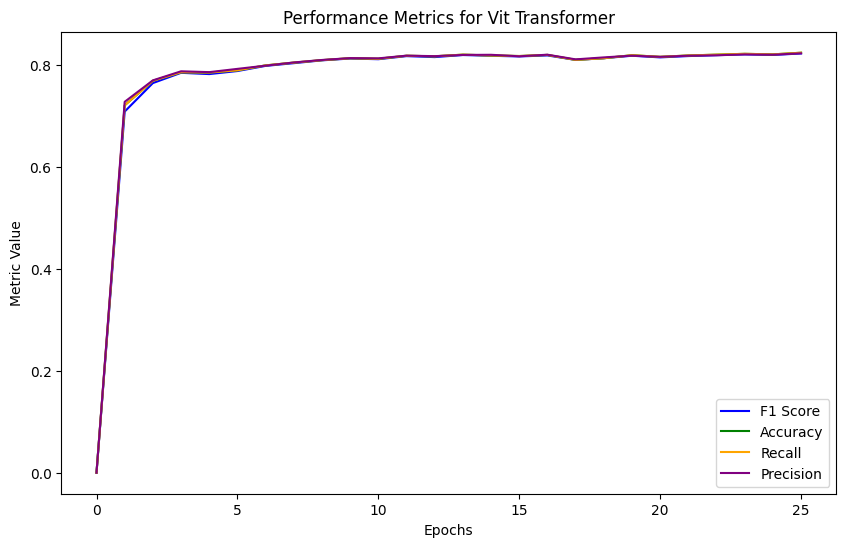

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
x_values = range(len(f1_vit))

plt.figure(figsize=(10, 6))
sns.lineplot(x=x_values, y= [float(item) for item in f1_vit], label="F1 Score", color="blue")
sns.lineplot(x=x_values, y=[float(item) for item in accuracy_vit], label="Accuracy", color="green")
sns.lineplot(x=x_values, y= [float(item) for item in recall_vit], label="Recall", color="orange")
sns.lineplot(x=x_values, y=[float(item) for item in precision_vit], label="Precision", color="purple")

plt.title("Performance Metrics for Vit Transformer")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")

plt.legend()
plt.show()

Finished Testing
Testing accuracy: 81.3 %
                        precision    recall  f1-score      support
Abstract_Expressionism   0.827465  0.848375  0.837790   277.000000
Baroque                  0.843537  0.864111  0.853701   287.000000
Cubism                   0.812785  0.767241  0.789357   232.000000
Fauvism                  0.514563  0.638554  0.569892    83.000000
Impressionism            0.876812  0.806667  0.840278   300.000000
Minimalism               0.824742  0.860215  0.842105    93.000000
Naive_Art_Primitivism    0.777311  0.764463  0.770833   242.000000
Pointillism              0.687500  0.767442  0.725275    43.000000
Rococo                   0.788889  0.788889  0.788889   180.000000
Ukiyo_e                  0.973214  0.956140  0.964602   114.000000
accuracy                 0.813074  0.813074  0.813074     0.813074
macro avg                0.792682  0.806210  0.798272  1851.000000
weighted avg             0.817364  0.813074  0.814481  1851.000000
--------------------

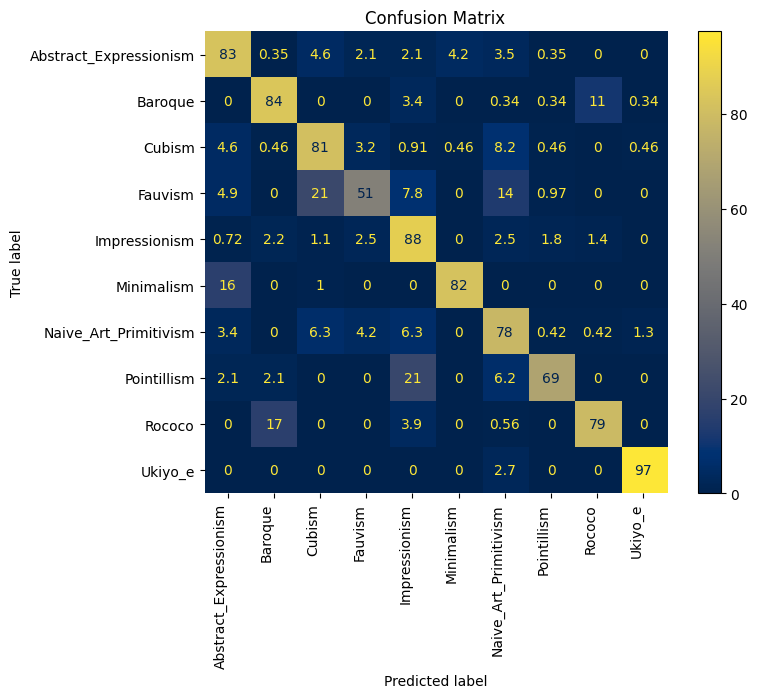

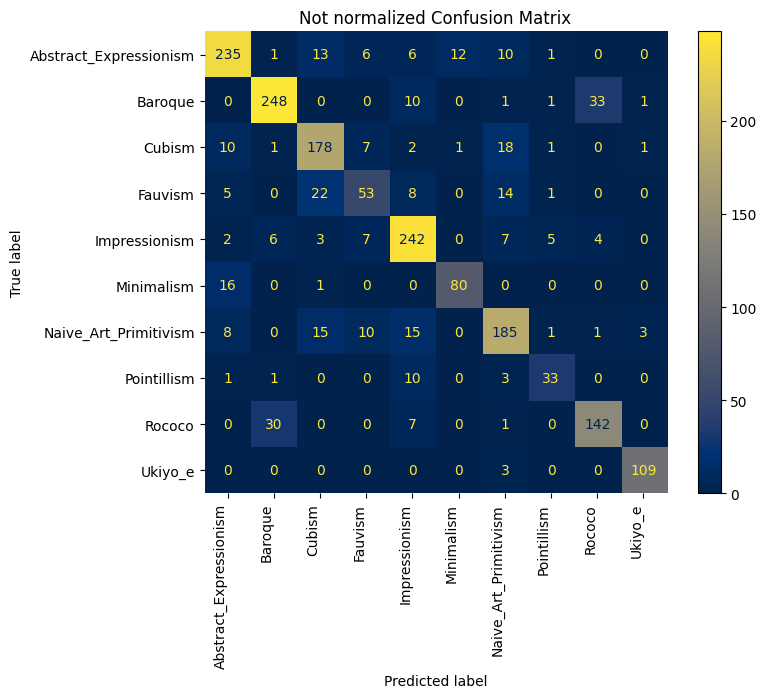

In [10]:
model1 = ViTClassifier.load_from_checkpoint(checkpoint_path="my/path/transformerVit-epoch=24-f1_val=0.82.ckpt",  num_classes=10)
model1.to(device)
validate_model(model1, val_loader)

In [ ]:
from google.colab import files
files.download('/content/my/path/transformerVit-epoch=14-f1_val=0.79.ckpt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install --upgrade pytorch-lightning


In [9]:
def evaluate_model(predicted, true):
  from sklearn.metrics import classification_report
  import pandas as pd
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
  import matplotlib.pyplot as plt
  report_dict = classification_report(predicted, true, target_names=class_names, output_dict=True)
  metrics_df2 = pd.DataFrame(report_dict).transpose()
  print(metrics_df2)
  print("-----------------------------------------------------------------------------------------------------------")
  cm =confusion_matrix(true, predicted, normalize = 'true')    
  disp = ConfusionMatrixDisplay(cm*100, display_labels=class_names)
  fig, ax = plt.subplots(figsize=(8, 6))
  disp.plot(cmap="cividis", ax=ax) 
  for _, spine in ax.spines.items():
        spine.set_visible(False)  
  plt.xticks(rotation=90, ha="right")
  plt.yticks(rotation=0)
  plt.grid(False) 
  plt.title("Confusion Matrix")
    #plt.colorbar(ax.collections[0], ax=ax)  
  disp = ConfusionMatrixDisplay(confusion_matrix(true, predicted), display_labels=class_names)

  fig, ax = plt.subplots(figsize=(8, 6))
  disp.plot(cmap="cividis", ax=ax) 
  for _, spine in ax.spines.items():
        spine.set_visible(False)  

  plt.xticks(rotation=90, ha="right")
  plt.yticks(rotation=0)
  plt.grid(False) 
  plt.title("Not normalized Confusion Matrix")
  plt.show()


  # Move model to the appropriate device (CPU or GPU)

def validate_model(model, data_loader):
    pred = []
    true = []
    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.extend(labels.cpu().numpy())
            pred.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total  # Calculate accuracy based on predictions

        print('Finished Testing')
        print(f'Testing accuracy: {accuracy:.1f} %')

    evaluate_model(pred, true)

In [ ]:
model11 = timm.create_model("vit_base_patch16_224", pretrained=True)
print(model11)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(